マスターブランチ  
https://github.com/maxpumperla/deep_learning_and_the_game_of_go

# まとめ
- 本章では，囲碁のルールを実装した．
- 盤上のどこに石が置かれているか，だけではなく，石の繋がり「連」を実装することによって石が囲われて取り除くルールを単純で高速に実現した.
- この連は，それを構成する石だけでなく，呼吸点が保持される
- 呼吸点を連に保持することで，自殺手を防ぐロジックを簡単に組み込める
- 劫を禁止するルールは，それまでの全ての盤を辿り，同じものがないかを調べることで実現する
- 打石をランダムなハッシュ値とし，そのXORで盤を表現するゾブリストハッシュによって，この検索を高速にしている．
    - これにより，frozensetにその盤のハッシュ値が存在するかを調べればよくなる．
- 配列のディープコピーを回避することでさらに高速に実装することができる
- 禁じ手を回避し，眼を潰さず，あとはランダムに石をおく，最弱ボットを実装した．これを以後発展させていく．
- 盤の状況をAAで出力する関数を作り，ボット同士の対戦と，人間とボットの対戦を可能にした

P73までのコードはモジュールとして実装  
dlgo/gotypes.py: データ型 Player, Pointを定義  
dlgo/goboard_slow.py: 囲碁のルール，着手(Move)，連(GoString)，打石のシステム(Board)を実装．自殺手と劫を禁じる  
dlgo/utils.py: 着手の内容と碁盤の状況出力(print_move, print_board)  
dlgo/agent/base.py: プレイヤーボットのインタフェース(Agent)  
dlgo/agent/helpers.py: 打石点が眼であるかを判定する関数(is_point_an_eye)を実装  
dlgo/agent/naive.py: 眼をつぶさず，禁じ手にならなければあとはランダムで打石する，最弱ボット(RandomBot)  

ボット同士で対局させる (bot_v_bot.pyを基に作成)

In [1]:
from dlgo import gotypes
# from dlgo import goboard_slow as goboard
from dlgo import goboard
from dlgo.agent.naive import RandomBot
from dlgo.utils import print_board, print_move, point_from_coords
import time
from six.moves import input
from IPython.display import clear_output

In [2]:
def bot_v_bot(board_size=19, sleep_time=1.0):
    game = goboard.GameState.new_game(board_size)
    bots = {
        gotypes.Player.black: RandomBot(),
        gotypes.Player.white: RandomBot()
    }

    while not game.is_over():
        time.sleep(sleep_time) # ボットの着手が早すぎるので見えるよう調整

        # print(chr(27) + "[2J") # 着手する前に画面をクリア
        clear_output()

        print_board(game.board)
        bot_move = bots[game.next_player].select_move(game)
        print_move(game.next_player, bot_move)
        game = game.apply_move(bot_move)

    print("GAME OVER!")

In [ ]:
bot_v_bot(9)

## ゾブリストハッシュによる高速化  
goboard_slow.pyでは劫を防ぐために着手のたびにそれまでの着手を全て辿っていたが，これは効率が悪い．  
そこで，碁盤の各状態を一つのハッシュ計算結果として表現するゾブリストハッシュを利用する．

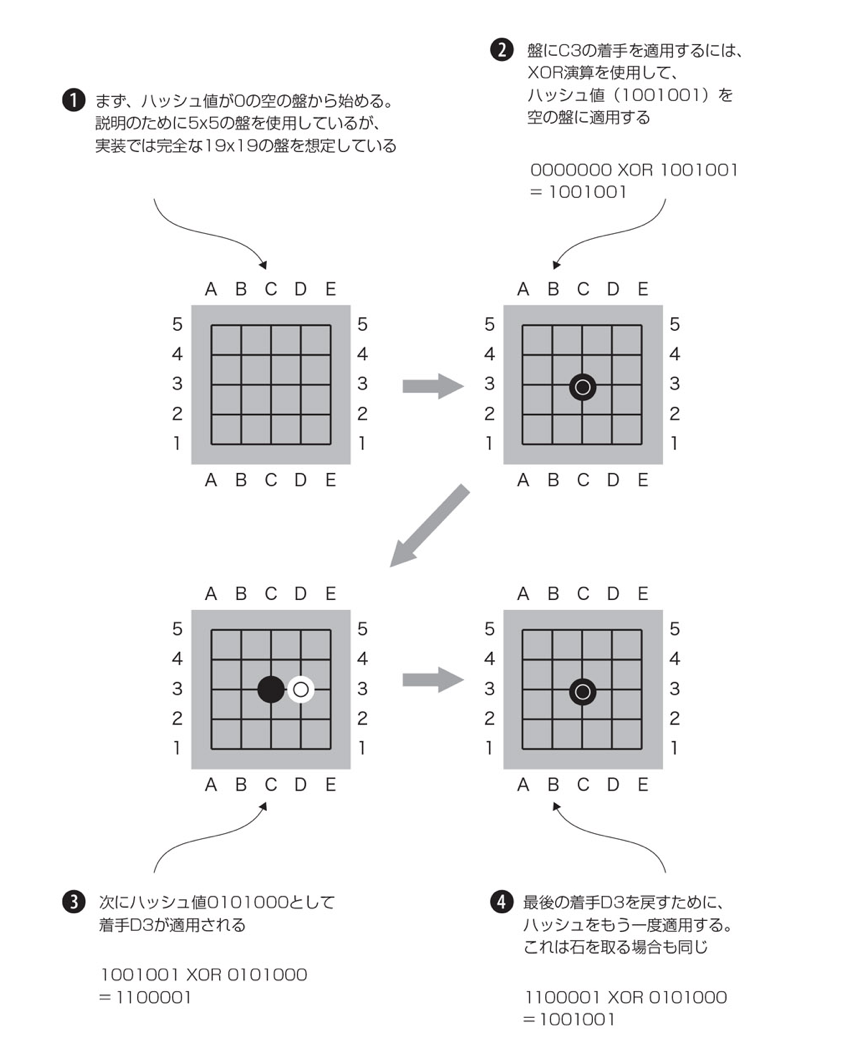

ざっくり仕組みを説明すると，
1. 一つの「打石場所, 石の色」につき一つの2値ハッシュ値をランダムで割り当てる
1. 全てのビットが0の値を何もない碁盤として用意する
1. 打石のたびにそのハッシュ値を盤のハッシュ値にXORで適用する
1. 石を取り除く時はそのハッシュ値をもう一度XORで適用すればよい
1. このようにして計算される碁盤のハッシュ値は，同じ碁盤の状態でなければ，ほぼ被ることはないとされている．ただし十分に長いビット数を用意すること．

ハッシュ値の割り当てを生成するには，generate_zobrish.pyを実行し，その出力をzobrish.pyに書き出す．  
あとは，goboard_slow.pyをコピーしgoboard.pyと名前をつけ，速度改善のための修正を行う．  
主なアイデアは，frozensetにプレイヤーと盤のハッシュ値のペアを保存していくこと.  
過去に同じ盤面があったかを確認するには，そのfrozensetに次のペアが存在するかを調べればよく，こちらの方が1桁高速らしい

In [ ]:
from dlgo import goboard as goboard
play_go(board_size=9)

さらに高速化するには，goboard_fast.pyをマスターブランチからもらってくる．  
こちらは，Pythonのオブジェクトの生成とコピーをなるべく避けることによる高速化がなされている．

## ボットとの対局

In [3]:
def human_v_bot(board_size=19):
    game = goboard.GameState.new_game(board_size)
    bot = RandomBot()
        
    while not game.is_over():
        
        # print(chr(27) + "[2J") # 着手する前に画面をクリア
        clear_output()
        print_board(game.board)
    
        if game.next_player == gotypes.Player.black:
            human_move = input('-- ')
            point = point_from_coords(human_move.strip())
            move = goboard.Move.play(point)
        else:
            move = bot.select_move(game)

        print_move(game.next_player, move)
        game = game.apply_move(move)

    print("GAME OVER!")

In [ ]:
human_v_bot(board_size=9)